In [1]:
import pandas as pd
import numpy as np
import nltk
import gensim
import gensim.downloader as gensim_api

import re

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\karth\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#loading the train and the test data
train = pd.read_csv("C:/Users/karth/Desktop/Dissertation/Data/AG_news_train.csv")
test = pd.read_csv("C:/Users/karth/Desktop/Dissertation/Data/AG_news_test.csv")
frames = [train,test]
data = pd.concat(frames)
data

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [3]:
data['Class Index'] = data['Class Index'].astype('str')
classes = {"1" : "World",
                     "2" : "Sports",
                     "3" : "Business",
                     "4" : "Sci&Tech"}

data['Class'] = data['Class Index'].map(classes)
data

,Class Index,Title,Description,Class
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business
...,...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,World
7596,2,Void is filled with Clement,With the supply of attractive pitching options...,Sports
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,Sports
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,Business


In [4]:
def text_preprocessing(text, flag_stemm=False, flag_lemma=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    #remove numbers from text
    text = re.sub("\d+", "", text)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flag_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flag_lemma == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    
    return text

lst_stopwords = nltk.corpus.stopwords.words("english")

In [5]:
##applying the text preprocessing function created to the entire dataset
data["cleaned_text"] = data["Description"].apply(lambda x: text_preprocessing(x, flag_stemm=False, flag_lemma=True, lst_stopwords=lst_stopwords))
data.head()

,Class Index,Title,Description,Class,cleaned_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business,reuters shortsellers wall street dwindlingband...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business,reuters private investment firm carlyle groupw...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business,reuters soaring crude price plus worriesabout ...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business,reuters authority halted oil exportflows main ...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business,afp tearaway world oil price toppling record s...


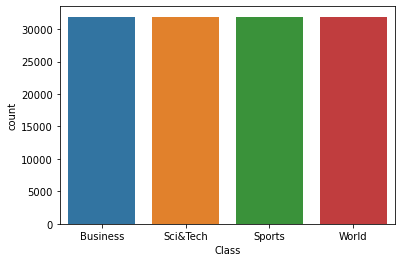

In [6]:
sns.countplot(x='Class', data=data)
# Show the plot
plt.show()

In [7]:
data_sample = data.groupby('Class').apply(lambda x: x.sample(n=5000)).reset_index(drop = True)
data_sample['Class'].value_counts()

World       5000
Sports      5000
Sci&Tech    5000
Business    5000
Name: Class, dtype: int64

In [8]:
# Importing libraries
import os
import sys
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [9]:
# make the max word length to be constant
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000
# the percentage of train test split to be applied
VALIDATION_SPLIT = 0.20
# the dimension of vectors to be used
EMBEDDING_DIM = 300
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 300
# dropout probability
drop = 0.5
batch_size = 500
epochs = 10

In [10]:
texts = data_sample['cleaned_text']
labels = data_sample.iloc[:, 0].astype(str)
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences =  tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels)

unique words : 32729
Shape of data tensor: (20000, 1000)
Shape of label tensor: (20000, 5)
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [11]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [12]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors
PATH = 'C:/Users/karth/Desktop/Dissertation/Code'
word_vectors = KeyedVectors.load_word2vec_format(PATH+'/GoogleNews-vectors-negative300.bin', binary=True)

EMBEDDING_DIM=300
        
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
    except KeyError:
        embedding_vector = 0
        
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [13]:
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [14]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=5, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights_cnn_sentece.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

(None, 1000, 300)
(None, 1000, 300, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 300)    9819000     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1000, 300, 1  0           ['embedding[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 998, 1, 512)  46

C:\Users\karth\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
print("Traning Model...")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Epoch 1/10
32/32 [==============================] - 2160s 67s/step - loss: 1.3221 - accuracy: 0.4321 - val_loss: 0.8321 - val_accuracy: 0.8045
Epoch 2/10
32/32 [==============================] - 2132s 67s/step - loss: 0.8174 - accuracy: 0.6969 - val_loss: 0.6121 - val_accuracy: 0.8322
Epoch 3/10
32/32 [==============================] - 1989s 62s/step - loss: 0.6473 - accuracy: 0.7782 - val_loss: 0.5291 - val_accuracy: 0.8425
Epoch 4/10
32/32 [==============================] - 2269s 71s/step - loss: 0.5589 - accuracy: 0.8102 - val_loss: 0.4900 - val_accuracy: 0.8545
Epoch 5/10
32/32 [==============================] - 2211s 69s/step - loss: 0.5152 - accuracy: 0.8269 - val_loss: 0.4654 - val_accuracy: 0.8543
Epoch 6/10
32/32 [==============================] - 2143s 67s/step - loss: 0.4776 - accuracy: 0.8365 - val_loss: 0.4481 - val_accuracy: 0.8575
Epoch 7/10
32/32 [==============================] - 1901s 60s/step - loss: 0.4564 - accuracy: 0.8463 - val_loss: 0.4345 - val

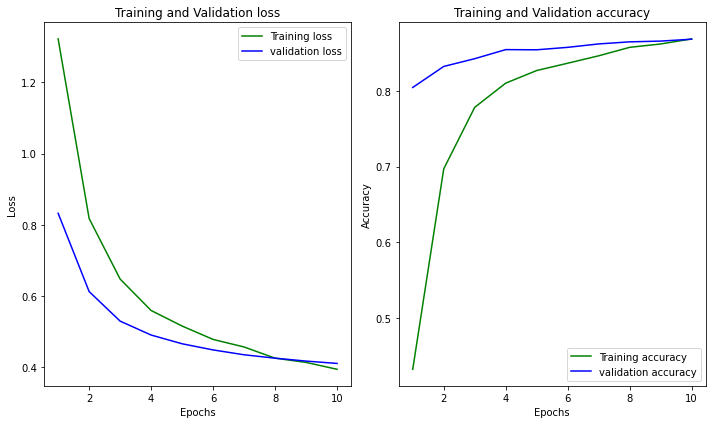

In [16]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = []
for x in range(1,11):
    epochs.append(x)
    
fig, (axes1, axes2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes1.plot(epochs, loss_train, 'g', label='Training loss')
axes1.plot(epochs, loss_val, 'b', label='validation loss')
axes1.title.set_text('Training and Validation loss')
axes1.set_xlabel('Epochs')
axes1.set_ylabel('Loss')
axes1.legend()

axes2.plot(epochs, acc_train, 'g', label='Training accuracy')
axes2.plot(epochs, acc_val, 'b', label='validation accuracy')
axes2.title.set_text('Training and Validation accuracy')
axes2.set_xlabel('Epochs')
axes2.set_ylabel('Accuracy')
axes2.legend()
fig.tight_layout()


              precision    recall  f1-score   support

    Business       0.88      0.87      0.87       952
     Sci&Tec       0.92      0.96      0.94      1033
      Sports       0.84      0.82      0.83      1025
       World       0.83      0.82      0.83       990

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



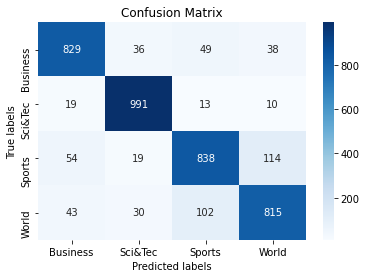

In [17]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt   
y_pred_ohe = model.predict(x_val)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
y_labels = np.argmax(y_val, axis=1)
target_names = ["Business","Sci&Tec","Sports","World"]
confusion_matrix = metrics.confusion_matrix(y_true=y_labels, y_pred=y_pred_labels)  # shape=(12, 12)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt="d",cmap='Blues',ax=ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

print(classification_report(y_labels, y_pred_labels, target_names=target_names))

In [18]:
# make the max word length to be constant
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000
# the percentage of train test split to be applied
VALIDATION_SPLIT = 0.20
# the dimension of vectors to be used
EMBEDDING_DIM = 100
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.5
batch_size = 500
epochs = 10

In [19]:
GLOVE_DIR = 'C:/Users/karth/Desktop/Dissertation/Code/'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [20]:
texts = data_sample['cleaned_text']
labels = data_sample.iloc[:, 0].astype(str)
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences =  tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels)

unique words : 32729
Shape of data tensor: (20000, 1000)
Shape of label tensor: (20000, 5)
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [21]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [22]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [23]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [24]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=5, activation='softmax')(dropout)

# this creates a model that includes
model1 = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights_cnn_sentece.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

(None, 1000, 100)
(None, 1000, 100, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1000, 100)    3273000     ['input_2[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 1000, 100, 1  0           ['embedding_1[0][0]']            
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 998, 1, 512)  

In [25]:
print("Traning Model...")
history1 = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Epoch 1/10
32/32 [==============================] - 790s 24s/step - loss: 1.4590 - accuracy: 0.4318 - val_loss: 0.6171 - val_accuracy: 0.8170
Epoch 2/10
32/32 [==============================] - 745s 23s/step - loss: 0.8007 - accuracy: 0.6957 - val_loss: 0.4770 - val_accuracy: 0.8422
Epoch 3/10
32/32 [==============================] - 743s 23s/step - loss: 0.6520 - accuracy: 0.7661 - val_loss: 0.4414 - val_accuracy: 0.8530
Epoch 4/10
32/32 [==============================] - 743s 23s/step - loss: 0.5889 - accuracy: 0.7943 - val_loss: 0.4252 - val_accuracy: 0.8615
Epoch 5/10
32/32 [==============================] - 751s 24s/step - loss: 0.5425 - accuracy: 0.8123 - val_loss: 0.4163 - val_accuracy: 0.8630
Epoch 6/10
32/32 [==============================] - 742s 23s/step - loss: 0.5090 - accuracy: 0.8256 - val_loss: 0.4071 - val_accuracy: 0.8640
Epoch 7/10
32/32 [==============================] - 741s 23s/step - loss: 0.4950 - accuracy: 0.8331 - val_loss: 0.4003 - val_accura

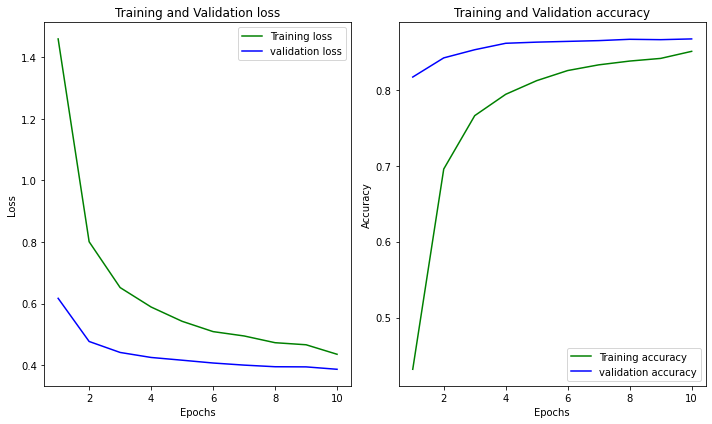

In [26]:
loss_train = history1.history['loss']
loss_val = history1.history['val_loss']
acc_train = history1.history['accuracy']
acc_val = history1.history['val_accuracy']
epochs = []
for x in range(1,11):
    epochs.append(x)
    
fig, (axes1, axes2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes1.plot(epochs, loss_train, 'g', label='Training loss')
axes1.plot(epochs, loss_val, 'b', label='validation loss')
axes1.title.set_text('Training and Validation loss')
axes1.set_xlabel('Epochs')
axes1.set_ylabel('Loss')
axes1.legend()

axes2.plot(epochs, acc_train, 'g', label='Training accuracy')
axes2.plot(epochs, acc_val, 'b', label='validation accuracy')
axes2.title.set_text('Training and Validation accuracy')
axes2.set_xlabel('Epochs')
axes2.set_ylabel('Accuracy')
axes2.legend()
fig.tight_layout()

              precision    recall  f1-score   support

    Business       0.89      0.89      0.89       953
     Sci&Tec       0.95      0.96      0.95      1025
      Sports       0.86      0.87      0.86      1017
       World       0.88      0.86      0.87      1005

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



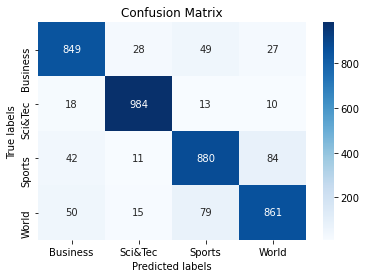

In [27]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt   
y_pred_ohe = model.predict(x_val)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
y_labels = np.argmax(y_val, axis=1)
target_names = ["Business","Sci&Tec","Sports","World"]
confusion_matrix = metrics.confusion_matrix(y_true=y_labels, y_pred=y_pred_labels)  # shape=(12, 12)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt="d",cmap='Blues',ax=ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

print(classification_report(y_labels, y_pred_labels, target_names=target_names))